# А/B тестирование 

В ходе анализа клиентских звонков банка "Т-Банк" была сформулирована гипотеза: увеличение льготного периода по кредитной карте позволит снизить долю отказов с причиной "Кредитная карта не нужна". <br>
Для проверки гипотезы был разработан и подготовлен датасет, отражающий результаты A/B-тестирования, основанный на исторических паттернах поведения клиентов.
В рамках набора данных содержалась следующая информация: <br>

group: контрольная или тестовая группа;<br>

success_flg: флаг успешного звонка (1 — успех); <br>

fail_reason: причина отказа (если звонок был неуспешным). <br>

Подготовленный датасет позволил провести предварительный анализ эффективности изменения оффера до фактического запуска эксперимента.

Заранее был проведен дизайн А/B теста, просчитаны минимальный детектируемый эффект (~4.5 п.п.), уровень значимости alpha = 0.05, мощность теста beta = 0.8 и размер выборки, который составил 4000 человек (по 2000 человек в каждой группе)

**Гипотезы**<br>
H0: Если льготный период составляет 55 дней, то доля отказов по причине «Кредитная карта не нужна» в тестовой группе не отличается от контрольной или снижение менее 10% относительно контрольной. <br>
H1: Если расширить льготный период до 120 дней на все покупки, то доля отказов по причине «Кредитная карта не нужна» в тестовой группе снижена минимум на 10% относительно контрольной группы (в относительном выражении).

## Анализ результатов

Импорт необходимых библиотек

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Читаем данные и записываем в переменную df

In [10]:
df = pd.read_csv('ab_test_simulated_credit_card.csv')
df

,group,success_flg,fail_reason
0,control,0,Другая причина
1,control,1,NaN
2,control,0,Другая причина
3,control,0,Другая причина
4,control,0,Кредитная карта не нужна
...,...,...,...
3995,test,0,Другая причина
3996,test,0,Кредитная карта не нужна
3997,test,0,Кредитная карта не нужна
3998,test,0,Другая причина


### Анализ результатов общей конверсии

,group,sum,count,conversion_rate
0,control,236,2000,0.1180
1,test,265,2000,0.1325


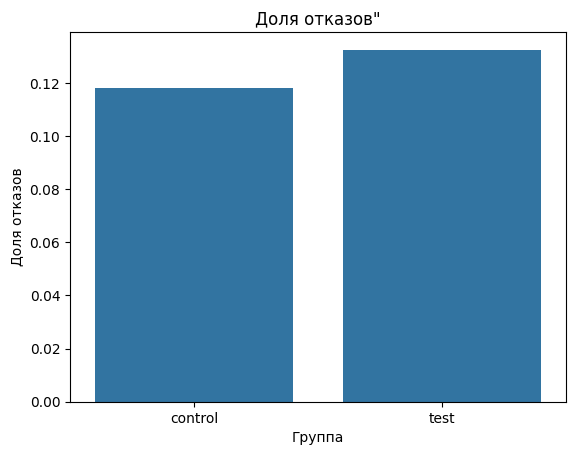

In [22]:
conversion_data = df.groupby('group')['success_flg'].agg(['sum', 'count']).reset_index()
conversion_data['conversion_rate'] = conversion_data['sum'] / conversion_data['count']

sns.barplot(data = conversion_data, x = 'group', y = 'conversion_rate')
plt.title('Доля отказов"')
plt.ylabel('Доля отказов')
plt.xlabel('Группа')
conversion_data

Разница между конверсиями групп составил 1.45 п.п. (12.3 % в относительных величинах). Далее проведем Z-test для оценки статистической значимости различий

In [20]:
from statsmodels.stats.proportion import proportions_ztest

successes = conversion_data['sum'].values
samples = conversion_data['count'].values


z_stat, p_value = proportions_ztest(count=successes, nobs=samples)

print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")


alpha = 0.05
if p_value < alpha:
    print("Различия статистически значимы — отвергаем H0.")
else:
    print("Различия НЕ статистически значимы — нет оснований отвергать H0.")

Z-статистика: -1.3853
p-value: 0.1660
Различия НЕ статистически значимы — нет оснований отвергать H0.


### Анализ доли отказов с причиной "Кредитная карта не нужна"

C:\Users\ILIYA\AppData\Local\Temp\ipykernel_19988\3741844792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fail_df['target_reason'] = fail_df['fail_reason'] == 'Кредитная карта не нужна'


,group,sum,count,fail_rate
0,control,776,1764,0.439909
1,test,684,1735,0.394236


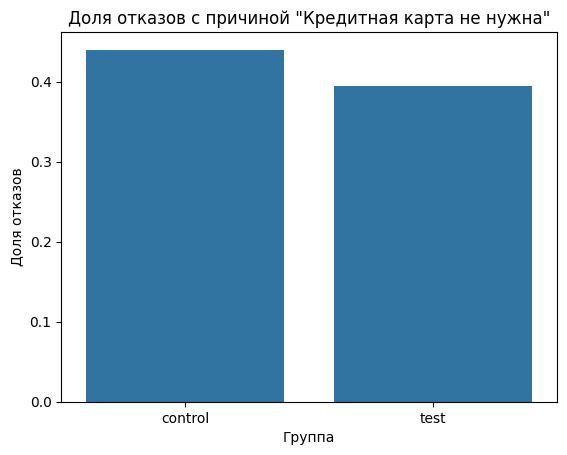

In [28]:
fail_df = df[(df['success_flg'] == 0)]

fail_df['target_reason'] = fail_df['fail_reason'] == 'Кредитная карта не нужна'

fail_reason_data = fail_df.groupby('group')['target_reason'].agg(['sum', 'count']).reset_index()
fail_reason_data['fail_rate'] = fail_reason_data['sum'] / fail_reason_data['count']

sns.barplot(data=fail_reason_data, x='group', y='fail_rate')
plt.title('Доля отказов с причиной "Кредитная карта не нужна"')
plt.ylabel('Доля отказов')
plt.xlabel('Группа')

fail_reason_data


Разница между конверсиями групп составил 4.56 п.п. (10.4 % в относительных величинах). Далее проведем Z-test для оценки статистической значимости различий

In [26]:
from statsmodels.stats.proportion import proportions_ztest


failures = fail_reason_data['sum'].values
fail_samples = fail_reason_data['count'].values

z_stat, p_value = proportions_ztest(count=failures, nobs=fail_samples)

print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.4f}")


alpha = 0.05
if p_value < alpha:
    print("Различия статистически значимы — гипотеза подтверждается.")
else:
    print("Различия НЕ статистически значимы — гипотеза не подтверждается.")


Z-статистика: 2.7393
P-значение: 0.0062
Различия статистически значимы — гипотеза подтверждается.


## Вывод

В ходе анализа был получен статистически значимый результат в изменении ключевой метрики (уменьшение конверсии отказов). Следовательно, можно отвергнуть нулевую гипотезу в пользу альтернативной и сделать вывод, что если расширить льготный период до 120 дней на все покупки, то доля отказов по причине «Кредитная карта не нужна» в тестовой группе снижена на 10.4% относительно контрольной группы (в относительном выражении).